In [1]:
from geneclusters.cluster_genes_new import *
path = './examples/test_dict.npy'
from assertpy import assert_that
from tqdm import tqdm
import numpy.ma as ma


In [2]:
get_kernighan_lin_clusters('./examples/test_dict.npy', 2, 0)

2it [00:00, 259.04it/s, tot_impr=3, last_impr=0, loss=2]


,0,description,is_gene
0,1,G1,True
1,0,G2,True
2,0,G3,True
3,1,G4,True
4,1,G5,True
5,0,P1,False
6,1,P2,False
7,0,P3,False


In [ ]:
# understand what the loss is and why we are summing g_maxes --> it seems like we are indirectly monitoring the loss?
# finish annotating cluster_genes_new functions
# finish writing tests for cluster_genes_new
# compare outputs (G and my code) on larger clustering example
# read up on bipartite graph clustering - does it make more sense to be doing this without the size constraints (see CMU lecture)?
# read the KL paper
# add output plotting functions (with FGSEA)
# finish README - add info, reasoning (lit review)?, and examples


In [4]:
path = './examples/test_dict.npy'
mat = get_gene_pathway_matrix(path)
mat

,G1,G2,G3,G4,G5
P1,1,1,1,0,0
P2,1,0,0,1,1
P3,0,1,0,1,0


In [262]:
path = './examples/test_dict.npy'
mat = get_gene_pathway_matrix(path)
pathway_names = mat.index
gene_names = mat.columns
matrix = np.ascontiguousarray(mat.values.T)
labeling = np.array([0, 0, 0, 1, 1, 1, 1, 0])

In [492]:
import numpy as np
import pandas as pd
from nltk import flatten

def get_gene_pathway_matrix(path_to_dict):
    '''
    returns pandas dataframe of pathways x genes indicating which pathway-gene pairs are key-value pairs in the input dictionary 
    Args:
        path_to_dict
            ndarray dictionary mapping pathway names to genes (e.g. as downloaded from GSEA)
    Returns:
        matrix ndarray
            gene x pathway matrix of edge weights
    '''
    paths = np.load(path_to_dict, allow_pickle=True).item()
    genes = np.unique(flatten(list(paths.values())))
    path_names = list(paths.keys())   
    output = np.empty(shape=[len(path_names), len(genes)], dtype = int)
    sets = [set(paths[x]) for x in path_names]
    df = pd.DataFrame([[x in y for x in genes] for y in sets])+0
    df.columns = genes
    df.index = path_names
    return df

def create_random_labeling(matrix, threshold):
    '''
    returns ndarray grouping pathways and genes into clusters based on threshold
    Args:
        matrix ndarray
            gene x pathway matrix
        threshold int
            number of genes per cluster. Min = 1, Max = total number of genes and pathways
    Returns:
        labeling 1D ndarray
            random cluster partition labels of length N-genes + N-pathways
    '''
    N = np.sum(matrix.shape)
    num_clusters = np.ceil(N / threshold)
    new_threshold = N / num_clusters
    labeling = (np.arange(N) / new_threshold).astype('int')
    np.random.shuffle(labeling)
    return labeling

def compute_costs(i, j, c, matrix):
    '''
    Compute cost between node i and j
    Args:
        i int
            index of first node (in labeling vector)
        j int
            index of second node (in labeling vector)
        c float 
            probability of false negative pathway-gene association (0<=c<= 1)
        matrix ndarray
            gene x pathway matrix
    Returns:
        cost float
            edge weight between node i and j
    '''
    x, y = matrix.shape
    if (i<x) & (j>=x):
        return np.max((matrix[i,j-x], c))
    if (j<x) & (i>=x):
        return np.max((matrix[j,i-x], c))
    if ((j<x) & (i<x)) | ((j>=x) & (i>=x)):
        return 0

def get_cross_costs(labeling, partition1, partition2, matrix, c):
    '''
    Compute pairwise costs of nodes in partition A and nodes in partition B
    Args:
        labeling 1D ndarray
            output vector from create_random_labeling()
        partition1 int
            cluster 1 label
        partition2 int
            cluster 2 label
        matrix ndarray
            gene x pathway matrix
        c float 
            probability of false negative pathway-gene association (0<=c<= 1)
    Returns:
        cost-matrix ndarray
            len(partition1) x len(partition2) matrix, where entries represent edge weights for pairwise nodes in partition1 and partition2
        
    ''' 
    partition1_indices = np.arange(len(labeling))[labeling==partition1]
    partition2_indices = np.arange(len(labeling))[labeling==partition2]
    L1 = len(partition1_indices)
    L2 = len(partition2_indices)
    cross_costs = np.empty(shape=(L1, L2))
    for i in range(L1):
        for j in range(L2):
            cross_costs[i, j] = compute_costs(partition1_indices[i], partition2_indices[j], c, matrix)
    return cross_costs, partition1_indices, partition2_indices

def compute_internal_cost(partition_indices, labeling, c, matrix, Ic):
    '''
    Compute internal cost for each node in partition A and save it to corresponding index in the Ic vector
    Args:
        partition_indices 1D ndarray (int) 
            index values for partition of interest in labeling vector
        labeling 1D ndarray
            output vector from create_random_labeling()
        c float 
            probability of false negative pathway-gene association (0<=c<= 1)
        matrix ndarray
            gene x pathway matrix
        Ic 1D ndarray
            empty vector of length = len(labeling)        
    '''
    for i in partition_indices:
        for j in partition_indices:
            if i!=j:
                Ic[i] += compute_costs(i, j, c, matrix)
            else:
                continue
                
def compute_external_cost(partition1_indices, partition2_indices, cross_costs, Ec):
    '''
    Compute external costs for each node in partitions A and B and save it to corresponding index in the Ec vector
    Args:
        partition_indices 1D ndarray (int) 
            index values for partitions of interest in labeling vector
        labeling 1D ndarray
            output vector from create_random_labeling()
        c float 
            probability of false negative pathway-gene association (0<=c<= 1)
        matrix ndarray
            gene x pathway matrix
        Ec 1D ndarray
            empty vector of length = len(labeling)        
    '''
    Ec[partition1_indices] = np.sum(cross_costs, axis = 1)
    Ec[partition2_indices] = np.sum(cross_costs, axis = 0)
    
### Is the external cost computed between A and B or between A and other?

In [493]:
def compute_cost_metrics(labeling, matrix, partition1, partition2, c):
    cross_costs, partition1_indices, partition2_indices = get_cross_costs(labeling, partition1, partition2, matrix, c)
    Ic = np.zeros(len(labeling), dtype = int)
    compute_internal_cost(partition1_indices, labeling, c, matrix, Ic)
    compute_internal_cost(partition2_indices, labeling, c, matrix, Ic)

    Ec = np.zeros(len(labeling), dtype = int)
    compute_external_cost(partition1_indices, partition2_indices, cross_costs, Ec)

    D = Ec-Ic
    return cross_costs, partition1_indices, partition2_indices, D

def kernighan_lin_step(labeling, matrix, partition1, partition2, c):
    iteration = np.floor(len(labeling)/2).astype(int)

    a_out = np.zeros(iteration)
    b_out = np.zeros(iteration)
    g_out = np.zeros(iteration)

    labeling_mask = np.zeros(labeling.shape)
    labeling_temp = labeling.copy()
    for it in range(iteration):
        #print('***')
        #print(it)
        cross_costs, partition1_indices, partition2_indices, D = compute_cost_metrics(labeling_temp, matrix, partition1, partition2, c)
        pairwise_d_sums = np.add.outer(D[partition1_indices], D[partition2_indices])
        g = pairwise_d_sums-2*cross_costs
        #print(g)

            ## something is going wrong after the first iteration here - check if the next iteration works..
        x, y = g.shape
        g_max_temp = np.argmax(g)
        i = g_max_temp // y
        j = g_max_temp % y

        index1 = partition1_indices[i]
        index2 = partition2_indices[j]

        a_out[it] = index1
        b_out[it] = index2
        g_out[it] = g[i,j]
        #print(g[i,j])

        labeling_mask[index1] = 1
        labeling_mask[index2] = 1
        labeling_temp = ma.masked_array(labeling_temp, mask = labeling_mask)

    cumulative_sum = np.cumsum(g_out)
    k = np.argmax(cumulative_sum)
    gmax = cumulative_sum[k]
    if gmax > 0:
        ra = a_out[:k+1].astype(int)
        rb = b_out[:k+1].astype(int)
        labeling[ra], labeling[rb] = labeling[rb], labeling[ra]
        return gmax
    else:
        return 0
    
def full_kl_step(labeling, matrix, c):
    num_clusters = len(set(labeling))
    order = np.random.permutation(num_clusters ** 2)
    impr = 0
    for o in order:
        cluster_1, cluster_2 = o // num_clusters, o % num_clusters
        impr+=kernighan_lin_step(labeling, matrix, cluster_1, cluster_2, c)
    return impr
    
# find k which maximizes the sum g_out[0], g_out[1]... g_out[k]
# if this sum is > 0:
#Exchange a_out[0] with b_out[0] up until k
# repeat from HERE until g_max <=0

In [503]:
def evaluate_cut(matrix, labeling, c):
    value = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if labeling[i] != labeling[j + matrix.shape[0]]:
                if matrix[i, j]:
                    value += 1
                else:
                    value += c
    return value

def run_KL(labeling, matrix, c):
    tot = 0
    with tqdm() as p:
        while True:
            impr = full_kl_step(labeling, matrix, c)
            tot += impr
            p.set_postfix({
                    'tot_impr': tot,
                    'last_impr': impr,
                    'loss': evaluate_cut(matrix, labeling, c)
            })
            p.update()
            if impr==0:
                break

In [504]:
labeling = np.array([0, 0, 0, 1, 1, 1, 1, 0])

run_KL(labeling, matrix, 0)

2it [00:00, 262.11it/s, tot_impr=3, last_impr=0, loss=2]


In [510]:
get_kernighan_lin_clusters('./examples/test_dict.npy', 2, 0)

2it [00:00, 280.16it/s, tot_impr=3, last_impr=0, loss=2]


,0,description,is_gene
0,1,G1,True
1,0,G2,True
2,0,G3,True
3,1,G4,True
4,1,G5,True
5,0,P1,False
6,1,P2,False
7,0,P3,False


In [521]:
get_kernighan_lin_clusters('./examples/test_dict.npy', 2, 0)

2it [00:00, 306.76it/s, tot_impr=3, last_impr=0, loss=2]


,0,description,is_gene
0,1,G1,True
1,0,G2,True
2,0,G3,True
3,1,G4,True
4,1,G5,True
5,0,P1,False
6,1,P2,False
7,0,P3,False


In [508]:
def get_kernighan_lin_clusters(path, threshold, C):
    '''
    returns pandas dataframe annotating each gene and pathway to a cluster, based on pathway-gene dictionary and args
    Args:
        path str
            path to pathway-gene dictionary as ndarray
        threshold int
            number of genes per cluster. Min = 1, Max = total number of genes and pathways
        C float
    '''
    mat = get_gene_pathway_matrix(path)
    pathway_names = mat.index
    gene_names = mat.columns
    matrix = np.ascontiguousarray(mat.values.T)
    labeling = np.array([0, 0, 0, 1, 1, 1, 1, 0])
    run_KL(labeling, matrix, 0)
    frame = pd.DataFrame(labeling)
    frame['description'] = np.concatenate([gene_names, pathway_names])
    frame['is_gene'] = np.arange(frame.shape[0]) < matrix.shape[0]
    return frame

In [501]:
labeling = np.array([0, 0, 0, 1, 1, 1, 1, 0])

tot = 0
with tqdm() as p:
    while True:
        impr = full_kl_step(labeling, matrix, 0)
        tot += impr
        p.set_postfix({
                'tot_impr': tot,
                'last_impr': impr,
                'loss': evaluate_cut(matrix, labeling, c)
        })
        p.update()
        if impr==0:
            break

2it [00:00, 169.59it/s, tot_impr=3, last_impr=0, loss=2]


In [ ]:
# understand what the loss is and why we are summing g_maxes --> it seems like we are indirectly monitoring the loss?
# annotate these functions
# write tests
# compare outputs on larger clustering example
# read up on bipartite graph clustering - does it make more sense to be doing this without the size constraints (see CMU lecture)?

evaluate_cut

In [495]:
# return all the other params like so in function above:
    tot = 0
    with tqdm() as p:
        while True:
            impr = full_kl_step(matrix, labeling, c)
            tot += impr
            p.set_postfix({
                'tot_impr': tot,
                'last_impr': impr,
                'loss': evaluate_cut(matrix, labeling, c)
            })
            p.update()
            if impr == 0:
                break
    return tot

array([1, 0, 0, 1, 1, 0, 1, 0])

In [487]:
labeling = np.array([0, 0, 0, 1, 1, 1, 1, 0])

full_kl_step(matrix, labeling, 0)

3.0

In [476]:
labeling

array([1, 0, 0, 1, 1, 0, 1, 0])

In [471]:
labeling = np.array([0, 0, 0, 1, 1, 1, 1, 0])

kernighan_lin_step(matrix, labeling, 0, 1, 0)

***
0
[[ 2.  1.  3. -1.]
 [ 0. -1.  1. -1.]
 [ 1.  0.  2.  0.]
 [-2. -1.  3. -1.]]
3.0
***
1
[[-inf -inf -inf -inf]
 [ -1.  -1. -inf  -4.]
 [ -3.  -1. -inf  -4.]
 [  0.  -2. -inf  -3.]]
0.0
***
2
[[-inf -inf -inf -inf]
 [-inf  -1. -inf  -2.]
 [-inf  -2. -inf  -1.]
 [-inf -inf -inf -inf]]
-1.0
***
3
[[-inf -inf -inf -inf]
 [-inf -inf -inf -inf]
 [-inf -inf -inf  -1.]
 [-inf -inf -inf -inf]]
-1.0


(3.0, 0)

In [472]:
labeling

array([1, 0, 0, 1, 1, 0, 1, 0])

In [520]:
# Credit: Guillaume Leclerc & Wikipedia 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from functools import partial
import numba as nb
from pdb import set_trace
import ipdb

def evaluate_cut(matrix, labeling, c):
    value = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if labeling[i] != labeling[j + matrix.shape[0]]:
                if matrix[i, j]:
                    value += 1
                else:
                    value += c
    return value
            
def create_random_labeling(matrix, threshold):
    '''
    **
    returns ndarray grouping pathways and genes into clusters based on threshold
    Args:
        matrix ndarray
            gene x pathway matrix
        threshold int
            number of genes per cluster. Min = 1, Max = total number of genes and pathways
    '''
    N = np.sum(matrix.shape)
    num_clusters = np.ceil(N / threshold)
    new_threshold = N / num_clusters
    labeling = (np.arange(N) / new_threshold).astype('int')
    np.random.shuffle(labeling)
    return labeling

#@nb.njit()
def get_cost(matrix, i, j, c):
    '''
    returns 
    Args:
        matrix ndarray
            gene x pathway matrix
        labeling 1D ndarray
        cluster_1 1D ndarray
            new labels for cluster_1
        cluster_2 1D ndarray
            new labels for cluster_2
        c float (0<= c <= 1)
            probability of false negative pathway-gene association
    '''
    if j < i:
        i, j = j, i
    if i >= matrix.shape[0]: # if i >matrix.shape[0], both i and j will index columns, so connection is zero
        return 0
    if j < matrix.shape[0]: # if j<matrix.shape[0], both j and i will index rows, so connection is zero
        return 0
    
    j -= matrix.shape[0] # j must index columns
    
    return max(matrix[i, j], c) # if connection is 0, return the probability of a false negative

#@nb.njit()
def cost_to_other(matrix, source, others, c):
    #set_trace()
    costs = np.zeros_like(source)
    for i, a in enumerate(source):
        for b in others:
            costs[i] += get_cost(matrix, a, b, c)
    return costs

def get_cross_costs(matrix, A, B, c):
    result = np.zeros((len(A), len(B)))
    for i, a in enumerate(A):
        for j, b in enumerate(B):
            result[i, j] = get_cost(matrix, a, b, c)
    return result

def get_pairwise_improvements(matrix, labeling, a, b, c):
    nodes_a = np.where(labeling == a)[0]
    nodes_b = np.where(labeling == b)[0]
    internal_a = cost_to_other(matrix, nodes_a, nodes_a, c)
    internal_b = cost_to_other(matrix, nodes_b, nodes_b, c)
    ext_a_to_b = cost_to_other(matrix, nodes_a, nodes_b, c)
    ext_b_to_a = cost_to_other(matrix, nodes_b, nodes_a, c)
    D_a = ext_a_to_b - internal_a # want to maximize internal costs and minimize external costs
    D_b = ext_b_to_a - internal_b
    cross_costs = get_cross_costs(matrix, nodes_a, nodes_b, c)
    all_improvements = np.zeros_like(cross_costs)
    for i in nb.prange(all_improvements.shape[0]):
        for j in range(all_improvements.shape[1]):
            all_improvements[i, j] = D_a[i] + D_b[j] - 2 * cross_costs[i , j] # cont here
    return all_improvements, nodes_a, nodes_b

def create_numba_int_list():
    l = List()
    l.append(32)
    l.pop()
    return l

def discard_done_swaps(all_improvements, done_a, done_b):
    for a in done_a:
        all_improvements[a, :] = -np.inf
    for b in done_b:
        all_improvements[:, b] = -np.inf

def kernighan_lin_step(matrix, labeling, cluster_1, cluster_2, c):
    '''
    returns 
    Args:
        matrix ndarray
            gene x pathway matrix
        labeling 1D ndarray
        cluster_1 1D ndarray
            new labels for cluster_1
        cluster_2 1D ndarray
            new labels for cluster_2
        c float (0<= c <= 1)
            probability of false negative pathway-gene association
    '''
    temp_labeling = labeling.copy()
    
    A = np.where(labeling == cluster_1)[0]
    B = np.where(labeling == cluster_2)[0]
    
    done_a = []
    done_b = []
    
    g = 0
    gs = []
    swaps = []
    
    for _ in range(min(len(A), len(B))):
        all_improvements, A, B = get_pairwise_improvements(matrix, temp_labeling, cluster_1, cluster_2, c)
        discard_done_swaps(all_improvements, done_a, done_b)
        
        ix = np.argmax(all_improvements)
        a, b = ix // all_improvements.shape[1], ix % all_improvements.shape[1]
        done_a.append(a)
        done_b.append(b)
        ra = A[a]
        rb = B[b]
        
        swaps.append((ra, rb))
        g += all_improvements[a, b]
        gs.append(g)
        temp_labeling[ra], temp_labeling[rb] = temp_labeling[rb], temp_labeling[ra]
            
    num_steps = np.argmax(np.array(gs))
    if gs[num_steps] > 0:
        for i in range(num_steps + 1):
            ra, rb = swaps[i]
            labeling[ra], labeling[rb] = labeling[rb], labeling[ra]

        return gs[num_steps]
    else:
        return 0
    
def full_kl_step(matrix, labeling, c):
    '''
    returns pandas dataframe annotating each gene and pathway to a cluster, based on pathway-gene dictionary and args
    Args:
        matrix ndarray
            gene x pathway matrix
        threshold int
            number of genes per cluster. Min = 1, Max = total number of genes and pathways
    '''
    num_clusters = len(set(labeling))
    order = np.random.permutation(num_clusters ** 2)
    
    impr = 0
    for o in order:
        cluster_1, cluster_2 = o // num_clusters, o % num_clusters # // floor division, % modulus
        impr += kernighan_lin_step(matrix, labeling, cluster_1, cluster_2, c)
    
    return impr
        
def kernighan_lin(matrix, labeling, c):
    '''
    iteratively performs kernighan lin steps
    Args:
        matrix ndarray
            gene x pathway matrix
        threshold int
            number of genes per cluster. Min = 1, Max = total number of genes and pathways
    '''
    tot = 0
    with tqdm() as p:
        while True:
            impr = full_kl_step(matrix, labeling, c)
            tot += impr
            p.set_postfix({
                'tot_impr': tot,
                'last_impr': impr,
                'loss': evaluate_cut(matrix, labeling, c)
            })
            p.update()
            if impr == 0:
                break
    return tot
    
def score_for_thres(matrix, thres, c):
    '''
    returns pandas dataframe annotating each gene and pathway to a cluster, based on pathway-gene dictionary and args
    Args:
        path str
            path to pathway-gene dictionary as ndarray
        threshold int
            number of genes per cluster. Min = 1, Max = total number of genes and pathways
        C float
    '''
    #labeling = create_random_labeling(matrix, thres)
    labeling = np.array([0, 0, 0, 1, 1, 1, 1, 0])

    kernighan_lin(matrix, labeling, c)
    return evaluate_cut(matrix, labeling, c), labeling

def get_kernighan_lin_clusters(path, threshold, C):
    '''
    returns pandas dataframe annotating each gene and pathway to a cluster, based on pathway-gene dictionary and args
    Args:
        path str
            path to pathway-gene dictionary as ndarray
        threshold int
            number of genes per cluster. Min = 1, Max = total number of genes and pathways
        C float
    '''
    mat = get_gene_pathway_matrix(path)
    pathway_names = mat.index
    gene_names = mat.columns
    matrix = np.ascontiguousarray(mat.values.T)
    results = score_for_thres(matrix, threshold, C)
    frame = pd.DataFrame(results[1])
    frame['description'] = np.concatenate([gene_names, pathway_names])
    frame['is_gene'] = np.arange(frame.shape[0]) < matrix.shape[0]
    return frame

  

#### below is scrap

In [200]:
out = list()
for i in tqdm(range(10000)):
    out.append(full_kl_step(labeling, matrix, 0))

100%|██████████| 10000/10000 [00:33<00:00, 295.93it/s]


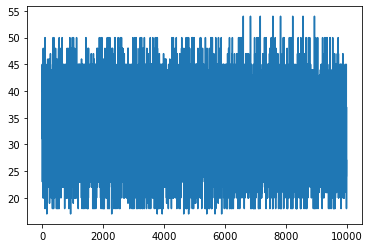

In [204]:
import matplotlib.pyplot as plt
plt.plot(range(10000), out)

In [199]:
np.min(out)

18.0

array([0, 0])

In [224]:
 #= 1

array([1, 1])

In [219]:
labeling[a_out[:k+1]]

IndexError: arrays used as indices must be of integer (or boolean) type

In [216]:
cumulative_sum = np.cumsum(g_out)
k = np.argmax(cumulative_sum)

In [217]:
k

1

In [205]:
# large gmax means large external cost
# why do we want to sum across all the g_outs and find k which maximizes that sum?

array([0., 2., 1., 7.])

1

In [206]:
b_out

array([5., 3., 4., 6.])

In [207]:
g_out

array([2., 3., 0., 0.])

In [209]:
partition1_indices

array([], dtype=int64)

In [178]:
a_out

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [181]:
D

array([ 2,  0,  1,  0, -1,  3, -1,  0])

In [128]:
labeling_mask[partition1_indices[i]] = 1
labeling_mask[partition2_indices[j]] = 1

In [129]:
labeling = ma.masked_array(labeling, mask = labeling_mask)

In [135]:
cross_costs, partition1_indices, partition2_indices = get_cross_costs(labeling, 0, 1, matrix, 0)
Ic = np.zeros(len(labeling), dtype = int)
compute_internal_cost(partition1_indices, labeling, 0, matrix, Ic)
compute_internal_cost(partition2_indices, labeling, 0, matrix, Ic)
    
Ec = np.zeros(len(labeling), dtype = int)
compute_external_cost(partition1_indices, partition2_indices, cross_costs, Ec)
    
D = Ec-Ic

In [136]:
cross_costs

array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.]])

In [138]:
D

array([ 0, -1,  0,  0, -1,  0, -2,  0])

In [132]:
np.arange(len(labeling))[labeling == 1]

array([3, 4, 6])

In [134]:
partition2_indices

array([3, 4, 5, 6])

In [83]:
x_indices = np.arange(x)
y_indices = np.arange(y)

In [112]:
mask = np.zeros(len(partition1_indices))
mask[i] = 1

In [118]:
import numpy.ma as ma

mask = np.zeros(len(partition1_indices))
mask[i] = 1

partition1_indices_masked = ma.masked_array(partition1_indices, mask)

mask = np.zeros(len(partition2_indices))
mask[j] = 1
partition2_indices_masked = ma.masked_array(partition2_indices, mask)

In [124]:
mask = np.zeros(cross_costs.shape)
mask[i] = 1
mask[:,j] = 1
cross_costs_masked = ma.masked_array(cross_costs, mask)

In [125]:
cross_costs_masked

masked_array(
  data=[[--, --, --, --],
        [0.0, 0.0, --, 0.0],
        [0.0, 0.0, --, 0.0],
        [1.0, 0.0, --, 0.0]],
  mask=[[ True,  True,  True,  True],
        [False, False,  True, False],
        [False, False,  True, False],
        [False, False,  True, False]],
  fill_value=1e+20)

In [120]:
partition2_indices_masked

masked_array(data=[3, 4, --, 6],
             mask=[False, False,  True, False],
       fill_value=999999)

In [106]:
len(partition1_indices)

4

In [78]:
cross_costs[mask]

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])

In [72]:
pairwise_d_sums = np.add.outer(D[partition1_indices], D[partition2_indices])
g = pairwise_d_sums-2*cross_costs
x, y = g.shape
g_max = np.argmax(g)
i = g_max // y
j = g_max % y

In [73]:
a[it] = partition1_indices[i]
b[it] = partition2_indices[j]
g[it] = g_max

# remove a and b nodes 
# update D values for remaining nodes

IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
if max_g<y:
    i = 0
    j = max_g


In [55]:
i = 8 // y
j = 8 % y

In [56]:
j

0

In [57]:
i

2

In [31]:
np.argmax(g)

2

In [34]:
g.ravel()

array([ 2.,  1.,  3., -1.,  0., -1.,  1., -1.,  1.,  0.,  2.,  0., -2.,
       -1.,  3., -1.])

In [90]:
def compute_costs(partition, labeling, matrix, C, internal = True):
    '''
    Compute internal or external cost Ic/Ec for each node in partition. Save costs in correpsonding entry of Ic vector.
    Args
        partition int
            partition label for which to compute internal cost for each node in partition
        labeling ndarray
            output of create_random_labeling
        matrix ndarray
            gene x pathway
        Ic 1D-ndarray 
            empty ndarray of length labeling
    '''
    partition_indices = np.arange(len(labeling))[labeling==partition]
    x,y = matrix.shape
    x_indices = partition_indices[partition_indices<x]
    y_indices = partition_indices[partition_indices>=x]
    
    if internal:
        matrix_subset = matrix[x_indices][:,y_indices-x]
        C[x_indices] = np.sum(matrix_subset, axis = 1)
        C[y_indices] = np.sum(matrix_subset, axis = 0)
    else:
        all_y = np.arange(y)
        all_x = np.arange(x)
        matrix_subset_x = matrix[x_indices][:,[i not in set(y_indices-x) for i in all_y]]
        matrix_subset_y = matrix[[i not in set(x_indices) for i in all_x]][:,y_indices-x]
        C[x_indices] = np.sum(matrix_subset_x, axis = 1)
        C[y_indices] = np.sum(matrix_subset_y, axis = 0)

In [108]:
def compute_all_costs(Ec, Ic):
    '''
    Compute per-node cost, given the current partitioning
    Args
        Ec 1D ndarray
            output of compute_costs(internal=False)
        Ic 1D ndarray
            output of compute_costs(internal=True)
    '''
    cross_costs, partition1_indices, partition2_indices = get_cross_costs(labeling, 0, 1, matrix, 0)
    Ic = np.zeros(len(labeling), dtype = int)
    compute_internal_cost(partition1_indices, labeling, 0, matrix, Ic)
    compute_internal_cost(partition2_indices, labeling, 0, matrix, Ic)
    
    Ec = np.zeros(len(labeling), dtype = int)
    compute_external_cost(partition1_indices, partition2_indices, cross_costs, Ec)
    
    D = Ec-Ic
    
    return D

In [186]:
def compute_costs(i, j, c, matrix):
    '''
    Compute cost between node a and b
    '''
    x, y = matrix.shape
    if (i<x) & (j>=x):
        return np.max((matrix[i,j-x], c))
    if (j<x) & (i>=x):
        return np.max((matrix[j,i-x], c))
    if ((j<x) & (i<x)) | ((j>=x) & (i>=x)):
        return 0

def get_cross_costs(labeling, partition1, partition2, matrix, c):
    '''
    Compute pairwise costs of nodes in parition A and nodes in partition B
    ''' 
    partition1_indices = np.arange(len(labeling))[labeling==partition1]
    partition2_indices = np.arange(len(labeling))[labeling==partition2]
    L1 = len(partition1_indices)
    L2 = len(partition2_indices)
    cross_costs = np.empty(shape=(L1, L2))
    for i in range(L1):
        for j in range(L2):
            cross_costs[i, j] = compute_costs(partition1_indices[i], partition2_indices[j], c, matrix)
    return cross_costs, partition1_indices, partition2_indices

In [175]:
def compute_internal_cost(partition_indices, labeling, c, matrix, Ic):
    for i in partition_indices:
        for j in partition_indices:
            if i!=j:
                Ic[i] += compute_costs(i, j, c, matrix)
            else:
                continue

In [187]:
def compute_external_cost(partition1_indices, partition2_indices, cross_costs, Ec):
    Ec[partition1_indices] = np.sum(cross_costs, axis = 1)
    Ec[partition2_indices] = np.sum(cross_costs, axis = 0)

In [180]:
Ic = np.zeros(len(labeling), dtype = int)
compute_internal_cost(0, labeling, 0, matrix, Ic)
compute_internal_cost(1, labeling, 0, matrix, Ic)

In [190]:
Ec = np.zeros(len(labeling), dtype = int)


In [191]:
compute_external_cost(partition1_indices, partition2_indices, cross_costs, Ec)

In [192]:
Ec

array([2, 1, 1, 1, 0, 3, 1, 1])

In [188]:
cross_costs, partition1_indices, partition2_indices = get_cross_costs(labeling, 0, 1, matrix, 0.1)

In [189]:
partition1_indices

array([0, 1, 2, 7])

In [159]:
partition1 = 0
partition2 = 1
partition1_indices = np.arange(len(labeling))[labeling==partition1]
partition2_indices = np.arange(len(labeling))[labeling==partition2]

In [161]:
partition1_indices

array([0, 1, 2, 7])

In [155]:
compute_costs(0, 5, 0.1, matrix)

1.0

In [139]:
x

2

In [87]:
all_x = np.arange(x)
matrix_subset_y = matrix[[i not in set(x_indices) for i in all_x]][:,y_indices-x]

In [88]:
matrix_subset_y

array([[1, 1],
       [1, 0],
       [1, 0]])

In [79]:
y_indices = partition_indices[partition_indices>=x]
y_indices-x

array([0, 1])

In [105]:
Ic = np.zeros(len(labeling), dtype = int)
compute_costs(0, labeling, matrix, Ic, internal = True)
compute_costs(1, labeling, matrix, Ic, internal = True)

In [106]:
Ic

array([0, 1, 0, 1, 1, 0, 2, 1])

In [99]:
Ec = np.zeros(len(labeling), dtype = int)
compute_costs(0, labeling, matrix, Ec, internal = False)
compute_costs(1, labeling, matrix, Ec, internal = False)
Ec_ground_truth = np.array([2, 1, 1, 1, 0, 3, 1, 1])

In [100]:
np.array_equal(Ec, Ec_ground_truth)

True

In [68]:
mat.T

,P1,P2,P3
G1,1,1,0
G2,1,0,1
G3,1,0,0
G4,0,1,1
G5,0,1,0


In [67]:
labeling

array([0, 0, 0, 1, 1, 1, 1, 0])

In [21]:
partition = 1
parition_indices = np.arange(len(labeling))[labeling==partition]

In [40]:
partition_indices = np.arange(len(labeling))[labeling==partition]
x,y = matrix.shape
x_indices = partition_indices[partition_indices<x]
y_indices = partition_indices[partition_indices>=x]-x

In [50]:
matrix_subset = matrix[x_indices][:,y_indices]

In [53]:
np.sum(matrix_subset, axis = 1)

array([1, 1])

In [44]:
partition_indices

array([3, 4, 5, 6])

In [45]:
matrix

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])

In [7]:
num_clusters
order = np.random.permutation(num_clusters ** 2)

In [8]:
order

array([ 4, 12, 11,  3,  2,  8,  9,  1,  7, 15, 13,  0, 14,  5, 10,  6])

In [13]:
4.5 % 2

0.5

In [2]:
mat = get_gene_pathway_matrix(path)

In [3]:
pathway_names = mat.index
gene_names = mat.columns

In [166]:
path = './examples/test_dict.npy'

mat = get_gene_pathway_matrix(path)
matrix = np.ascontiguousarray(mat.values.T)
N = np.sum(matrix.shape)
out = np.empty(shape = (N-1, N), dtype = int)

# get random labels for allowed thresholds
for x in range(1, N):
    out[x-1] = create_random_labeling(matrix, x)

# check expected number of clusters
for i in range(out.shape[0]):
    uniques = np.unique(out[i], return_counts = True)
    nclust = np.ceil(N/(i+1))
    assert_that(len(uniques[0])==nclust).is_true()
    
    if (N/nclust)%1 >0:
        # check expected number of genes per cluster
        assert_that(len(np.unique(uniques[1]))==2).is_true()
    else:
        assert_that(len(np.unique(uniques[1]))==1).is_true()
    

ValueError: could not broadcast input array from shape (8,) into shape (200,)

In [168]:
200/3

66.66666666666667

True
True
True
True
True
True
True


In [153]:
if (N/nclust)%1 >0:
    len(np.unique(uniques[1]))==2
else:
    len(np.unique(uniques[1]))==1
    

1

In [154]:
550%

0

In [151]:
5.5/1

5.5

In [89]:
N/2

4.0

In [61]:
np.unique(create_random_labeling(matrix, 5), return_counts = True)[1]

array([4, 4])

0.16

In [36]:
new_threshold = 2/np.ceil(N/7)
labeling = (np.arange(N) / new_threshold).astype('int')
labeling

array([0, 1, 2, 3, 4, 5, 6, 7])

In [6]:
N = np.sum(matrix.shape)
N

8

In [25]:
num_clusters = np.ceil(N / 2)
labeling = (np.arange(N) / new_threshold).astype('int')
np.random.shuffle(labeling)

NameError: name 'labeling' is not defined

In [23]:
new_threshold = N / num_clusters
new_threshold

2.0

In [2]:
mat = get_gene_pathway_matrix(path)
pathway_names = mat.index
gene_names = mat.columns
matrix = np.ascontiguousarray(mat.values.T)
labeling = create_random_labeling(matrix, 2)

num_clusters = len(set(labeling))
order = np.random.permutation(num_clusters ** 2)
o = order[0]
cluster_1, cluster_2 = o // num_clusters, o % num_clusters

In [3]:
temp_labeling = labeling.copy()
A = np.where(labeling == cluster_1)[0]
B = np.where(labeling == cluster_2)[0]
    
done_a = []
done_b = []
    
g = 0
gs = []
swaps = []

nodes_a = np.where(labeling == cluster_1)[0]
nodes_b = np.where(labeling == cluster_2)[0]

In [4]:
internal_a = cost_to_other(matrix, nodes_a, nodes_a, 0.2)

> /home/gridsan/djuna/homer/github/geneclusters/geneclusters/cluster_genes.py(70)cost_to_other()
     68 def cost_to_other(matrix, source, others, c):
     69     set_trace()
---> 70     costs = np.zeros_like(source)
     71     for i, a in enumerate(source):
     72         for b in others:



ipdb>  n


> /home/gridsan/djuna/homer/github/geneclusters/geneclusters/cluster_genes.py(71)cost_to_other()
     69     set_trace()
     70     costs = np.zeros_like(source)
---> 71     for i, a in enumerate(source):
     72         for b in others:
     73             costs[i] += get_cost(matrix, a, b, c)



ipdb>  n


> /home/gridsan/djuna/homer/github/geneclusters/geneclusters/cluster_genes.py(72)cost_to_other()
     70     costs = np.zeros_like(source)
     71     for i, a in enumerate(source):
---> 72         for b in others:
     73             costs[i] += get_cost(matrix, a, b, c)
     74     return costs



ipdb>  i


0


ipdb>  a


matrix = array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])
source = array([2, 5])
others = array([2, 5])
c = 0.2


ipdb>  source


*** SyntaxError: unexpected EOF while parsing


ipdb>  source


*** SyntaxError: unexpected EOF while parsing


ipdb>  costs


array([0, 0])


ipdb>  others


array([2, 5])


ipdb>  source


*** SyntaxError: unexpected EOF while parsing


ipdb>  nodes_a


*** NameError: name 'nodes_a' is not defined


ipdb>  others[0]


2


ipdb>  source[0]


*** module, class, method, function, traceback, frame, or code object was expected, got list


ipdb>  jj = 5
ipdb>  i


0


ipdb>  matrix


array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])


ipdb>  matrix.shape


(5, 3)


ipdb>  matrix.shape[0]


5


ipdb>  exit


BdbQuit: 

In [5]:
np.random.seed(4)

In [6]:
np.random.randn()


0.05056170714293955

In [7]:
np.random.randn()



0.499951333237829

In [7]:
from geneclusters.prepare_inputs import *
from geneclusters.cluster_genes import *
path = './examples/test_dict.npy'
mat = get_gene_pathway_matrix(path)
pathway_names = mat.index
gene_names = mat.columns
matrix = np.ascontiguousarray(mat.values.T)
labeling = create_random_labeling(matrix, 2)


In [14]:
# one KL step
num_clusters = len(set(labeling))
order = np.random.permutation(num_clusters ** 2)
o = order[0]
cluster_1, cluster_2 = o // num_clusters, o % num_clusters
temp_labeling = labeling.copy()

In [15]:
A = np.where(labeling == cluster_1)[0]
B = np.where(labeling == cluster_2)[0]
    
done_a = []
done_b = []
    
g = 0
gs = []
swaps = []

In [22]:
A

array([0, 2])

In [24]:
from pdb import set_trace

In [57]:
from geneclusters.prepare_inputs import *
from assertpy import assert_that


In [3]:
mat = get_gene_pathway_matrix(path)

In [20]:
pathway = np.load(path, allow_pickle = True).items()

In [18]:
pathway['15q11.2 copy number variation syndrome WP4940']

['CYFIP1',
 'TUBGCP2',
 'TUBGCP3',
 'FMR1',
 'NIPA2',
 'TUBGCP6',
 'NIPA1',
 'TUBGCP4',
 'TUBGCP5']

In [1]:
my_dict = {'P1':['G1', 'G2', 'G3'], 'P2': ['G1', 'G4', 'G5'], 'P3': ['G2', 'G4']}

In [4]:
import numpy as np
np.save('./examples/test_dict.npy', my_dict)

In [60]:
my_dict = np.load('./examples/test_dict.npy', allow_pickle=True).item()

In [62]:
path = './examples/test_dict.npy'

In [63]:
mat = get_gene_pathway_matrix(path)

In [64]:
pathway_names = mat.index
gene_names = mat.columns
matrix = np.ascontiguousarray(mat.values.T)

In [65]:
matrix

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])

In [66]:
gene_names

Index(['G1', 'G2', 'G3', 'G4', 'G5'], dtype='object')

In [67]:
create_random_labeling(matrix, thres)

Index(['P1', 'P2', 'P3'], dtype='object')

In [68]:
def create_random_labeling(matrix, threshold):
    N = np.sum(matrix.shape)
    num_clusters = np.ceil(N / threshold)
    new_threshold = N / num_clusters
    labeling = (np.arange(N) / new_threshold).astype('int')
    np.random.shuffle(labeling)
    return labeling

In [71]:
create_random_labeling(matrix, 1)

array([1, 6, 5, 2, 3, 7, 4, 0])

In [72]:
N = np.sum(matrix.shape)
N

8

In [80]:
num_clusters = np.ceil(N / 2)
new_threshold = N / num_clusters
new_threshold

2.0

In [88]:
num_clusters = np.ceil(N / 2.5)

In [89]:
num_clusters

4.0

In [83]:
labeling = (np.arange(N) / new_threshold).astype('int')
labeling

array([0, 0, 1, 1, 2, 2, 3, 3])

In [84]:
np.random.shuffle(labeling)

In [91]:
labeling = create_random_labeling(matrix, 2)

In [93]:
matrix

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])

In [95]:
num_clusters = len(set(labeling))

In [97]:
order = np.random.permutation(num_clusters ** 2)

In [98]:
order

array([ 4, 13, 10, 14,  6,  8,  2, 12,  9, 15,  1,  5,  7,  3, 11,  0])

In [108]:
10 // 3

3

In [110]:
labeling = create_random_labeling(matrix, 2)

In [112]:
num_clusters = len(set(labeling))
order = np.random.permutation(num_clusters ** 2)

In [129]:
o = order[2]
cluster_1, cluster_2 = o // num_clusters, o % num_clusters

In [130]:
temp_labeling = labeling.copy()
A = np.where(labeling == cluster_1)[0]

In [131]:
B = np.where(labeling == cluster_2)[0]

In [132]:
A

array([0, 5])

In [137]:
result = np.zeros((len(A), len(B)))
for i in enumerate(A):
    print(i)

(0, 0)
(1, 5)


In [139]:
matrix

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])

In [141]:
costs = np.zeros_like(A)

In [144]:
for i, a in enumerate(costs):
    print(i)
    print(a)

0
0
1
0


In [148]:
j = 2
j -= matrix.shape[0]

In [150]:
matrix[0,j]

1

In [154]:
def get_cost(matrix, i, j, c):
    '''
    returns 
    Args:
        matrix ndarray
            gene x pathway matrix
        labeling 1D ndarray
        cluster_1 1D ndarray
            new labels for cluster_1
        cluster_2 1D ndarray
            new labels for cluster_2
        c float (0<= c <= 1)
            probability of false negative pathway-gene association
    '''
    if j < i:
        i, j = j, i
    if i >= matrix.shape[0]:
        return 0
    if j < matrix.shape[0]:
        return 0
    
    j -= matrix.shape[0]
    
    return max(matrix[i, j], c)

def cost_to_other(matrix, source, others, c):
    costs = np.zeros_like(source)
    for i, a in enumerate(source):
        for b in others:
            costs[i] += get_cost(matrix, a, b, c)
    return costs

In [158]:
cost_to_other(matrix, A, B, 0)

array([1, 0])

In [159]:
matrix

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])

In [162]:
labeling

array([1, 3, 0, 0, 2, 1, 2, 3])